<a href="https://colab.research.google.com/github/marathomas/meerkat/blob/master/04_meerkat_spec_manipulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Embedding analysis through spectrogram manipulation

The aim of this script is to evaluate an embedding by manipulating spectrograms and assessing the influence of these manipulations on the euclidean distance in the embedded space.

# Prerequisites

## Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading libraries

In [ ]:
import os
import pandas as pd
import sys
os.system('pip install "librosa==0.7.1"')
import librosa
import numpy as np
import statistics
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.legend import Legend
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc, gridspec
import matplotlib
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import umap
from scipy.stats import zscore
from sklearn import metrics
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.legend import Legend
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc, gridspec
import matplotlib
import seaborn as sns
from matplotlib.text import Annotation
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
import scipy
from scipy.spatial.distance import euclidean as euclid
from scipy.spatial import distance_matrix

# for 3D arrow annotation
# https://gist.github.com/WetHat/1d6cd0f7309535311a539b42cccca89c

class Annotation3D(Annotation):
    def __init__(self, text, xyz, *args, **kwargs):
        super().__init__(text, xy=(0,0), *args, **kwargs)
        self._xyz = xyz

    def draw(self, renderer):
        x2, y2, z2 = proj_transform(*self._xyz, renderer.M)
        self.xy=(x2,y2)
        super().draw(renderer)

def _annotate3D(ax,text, xyz, *args, **kwargs):
    '''Add anotation `text` to an `Axes3d` instance.'''

    annotation= Annotation3D(text, xyz, *args, **kwargs)
    ax.add_artist(annotation)

setattr(Axes3D,'annotate3D',_annotate3D)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Constants

In [ ]:
PROJECT_PATH = "/content/drive/My Drive/meerkat/" 
FIGURES = PROJECT_PATH+"figures/"
DATA = PROJECT_PATH+"data/"

os.chdir(PROJECT_PATH)

In [ ]:
# Spectrogramming paramters

FFT_WIN = 0.03 # FFT_WIN*samplerate = length of fft/n_fft (number of audio frames that go in one fft)
FFT_HOP = FFT_WIN/8 # FFT_HOP*samplerate = n of audio frames between successive ffts
N_MELS = 40 # number of mel bins
WINDOW = 'hann' # each frame of audio is windowed by a window function (its length can also be
# determined and is then padded with zeros to match n_fft. we use window_length = length of fft
N_MFCC = 13 # Number of cepstral coefficients
#SR = 48000
#SR = 22050 # for padded
FMAX = 4000
MAX_DURATION = 0.5

## Functions

In [ ]:
# Function that generates mel spectrogram from audio data
# Input: data: Audio data (np array of floats), 
#        rate: samplerate in Hz (integer)
#        n_mels: number of mel bands (integer)
#        window: spectrogram window generation type (String)
#        fft_win: window length in s (float)
#        fft_hop: hop between window start in s (float)
# Output: Spectrogram (np array of floats)

def generate_mel_spectrogram(data, rate, n_mels, window, fft_win , fft_hop):
    n_fft  = int(fft_win * rate) 
    hop_length = int(fft_hop * rate) 
        
    s = librosa.feature.melspectrogram(y = data ,
                                       sr = rate, 
                                       n_mels = n_mels , 
                                       fmax = 4000, 
                                       n_fft = n_fft,
                                       hop_length = hop_length, 
                                       window = window, 
                                       win_length = n_fft)

    spectro = librosa.power_to_db(s, ref=np.max)

    return spectro


# Function that pads a spectrogram with zeros to a certain length
# Input: spectrogram (2D np array)
#        maximal length (Integer)
# Output: Padded spectrogram (2D np array)

def pad_spectro(spec,maxlen):
  padding = maxlen - spec.shape[1]
  z = np.zeros((spec.shape[0],padding))
  padded_spec=np.append(spec, z, axis=1)
  return padded_spec

def generate_stretched_mel_spectrogram(data, sr, duration, n_mels, window, fft_win , fft_hop):
    n_fft  = int(fft_win * sr) 
    hop_length = int(fft_hop * sr) 
    stretch_rate = duration/MAX_DURATION

    D = librosa.stft(y=data, # spectrogramming
                     n_fft = n_fft,
                     hop_length = hop_length,
                     window=window,
                     win_length = n_fft
                     )
    
    D_stretched = librosa.core.phase_vocoder(D, stretch_rate, hop_length=hop_length) # stretch spectrogram
    
    s = librosa.feature.melspectrogram(S=D_stretched,  # mel transform
                                       sr=sr,
                                       n_mels=n_mels,
                                       fmax=FMAX)
        
    spectro = librosa.power_to_db(np.abs(s)**2, ref=np.max) # power to db transform

    return spectro

# Analysis

After all, embeddings are just dim-reduced spectrograms, so makes sense to test with the spectrograms.

In [ ]:
df_name = '2020-09-20_embedding_denoised_melspectro_focal_focal'
df = pd.read_pickle(DATA+'df_denoised_balanced')
df = df[df.nonfocal_yn == 'n'] # for focal
df.reset_index(inplace=True)

Randomly sample an example for each calltype

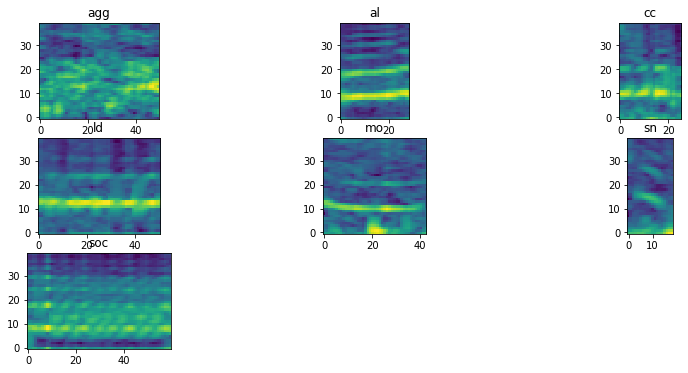

In [ ]:
call_dict={}
calltypes = sorted(list(set(df['call_lable'])))
for calltype in calltypes:
  example = df.loc[df['call_lable']==calltype,:].sample(n=1,replace=True).squeeze()
  call_dict[calltype] = example

fig = plt.figure(figsize=(14,6))
k=1

# Show examples
for calltype in calltypes:
  img_of_interest = call_dict[calltype].denoised_spectrograms
  plt.subplot(3, 3, k)
  plt.imshow(img_of_interest, interpolation='nearest', origin='lower', aspect='equal') 
  plt.title(calltype)
  k=k+1

## Functions

In [ ]:
# shift timeframes to the right
def generate_timeshifted(original_spec):

  augmented_specs = []
  
  for k in range(1,(MAXLEN-original_spec.shape[1])):
    addition = np.zeros((original_spec.shape[0], k))
    augmented = np.append(addition, original_spec, axis=1)
    augmented_specs.append(augmented)

  return augmented_specs


# generate different stretches. need orignal raw-audio to do this.
def generate_stretched(audio_data, dur, sr):

    augmented_specs = []

    durations = np.linspace(0.01, MAX_DURATION-0.05, num=40)

    if dur not in durations:
      previous_element = np.max(durations[durations<dur])
      desired_index = np.where(durations==previous_element)[0][0]+1
      durations = np.insert(durations, desired_index, dur)

    n_fft  = int(FFT_WIN * sr) 
    hop_length = int(FFT_HOP * sr)
    
    for desired_duration in durations:
 
      stretch_rate = dur/desired_duration
      D = librosa.stft(y=audio_data, 
                       n_fft = n_fft,
                       hop_length = hop_length,
                       window=WINDOW,
                       win_length = n_fft
                       )
    
      D_stretched = librosa.core.phase_vocoder(D, stretch_rate, hop_length=hop_length) # stretch spectrogram
      D_stretched = librosa.power_to_db(np.abs(D_stretched)**2, ref=np.max) # power to db transform

    
      spectro = librosa.feature.melspectrogram(S=D_stretched,  # mel transform
                                               sr=sr,
                                               n_mels=N_MELS,
                                               fmax=FMAX)
        
      #spectro = librosa.power_to_db(np.abs(s)**2, ref=np.max) # power to db transform
      
      # Denoise
      spectro = spectro-np.median(spectro, axis=0)
      
      augmented_specs.append(spectro)

    return augmented_specs


def generate_freqshifted(original_spec):

  augmented_specs = []
  
  for k in range(1,N_MELS):
    upper = original_spec[0:k,:]
    lower = original_spec[k:,:]

    augmented = np.concatenate((lower, upper), axis=0)
    augmented_specs.append(augmented)

  return augmented_specs




def generate_augmented(call, augment_type):
  augmented = []

  if augment_type=='stretch':
    augmented = generate_stretched(call.raw_audio, call.duration_s, call.samplerate_hz)
  elif augment_type=='timeshift':
    augmented = generate_timeshifted(call.denoised_spectrograms)
  elif augment_type=='freqshift':
    augmented = generate_freqshifted(call.denoised_spectrograms)
  else:
    print('Augmenttype not recognized')
  
  return augmented

## Produce augmented spectrograms

In [ ]:
calltype = 'sn'
augment_type = 'stretch'

In [ ]:
specs = list(df.denoised_spectrograms.values) # now array of 2D arrays n_mels+time_frames(varying)
MAXLEN = np.max([spec.shape[1] for spec in specs])

original_spec = call_dict[calltype].denoised_spectrograms

augmented_specs = generate_augmented(call_dict[calltype], augment_type)

# Insert original if not present
#lens = [spec.shape[1] for spec in augmented_specs]
#if original_spec.shape[1] not in lens:
#  previous_element = max([t for t in lens if t < original_spec.shape[1]])
#  desired_index = lens.index(previous_element)
#  augmented_specs.insert(desired_index, original_spec)

# Add augmented to dataframe
specs = specs+augmented_specs
len(specs)

# Create data
flattened_specs = [pad_spectro(spec, MAXLEN).flatten() for spec in specs]
data = np.asarray(flattened_specs)
# Normalize
#data = StandardScaler().fit_transform(pd.DataFrame(data))

### Full spectrograms

In [ ]:
embedding = data[df.loc[df['index_id'] == call_dict[calltype].index_id,:].index[0],:]
augmented_embeddings = data[-(len(augmented_specs)):,:]

if augment_type=='stretch':
  lens = [spec.shape[1] for spec in augmented_specs]
  zero_stretch_index = lens.index(original_spec.shape[1])
  embedding = augmented_embeddings[zero_stretch_index,:]
  original_spec = augmented_specs[zero_stretch_index]

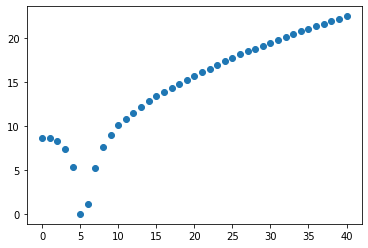

In [ ]:
distances = [euclid(embedding, augmented_embeddings[i,:]) for i in range(0,len(augmented_specs))]
plt.scatter(range(len(augmented_specs)), distances)

In [ ]:
if augment_type!='freqshift':
  original_spec = pad_spectro(original_spec, MAXLEN)
  augmented_specs = [pad_spectro(x, MAXLEN) for x in augmented_specs]

#### Visualization

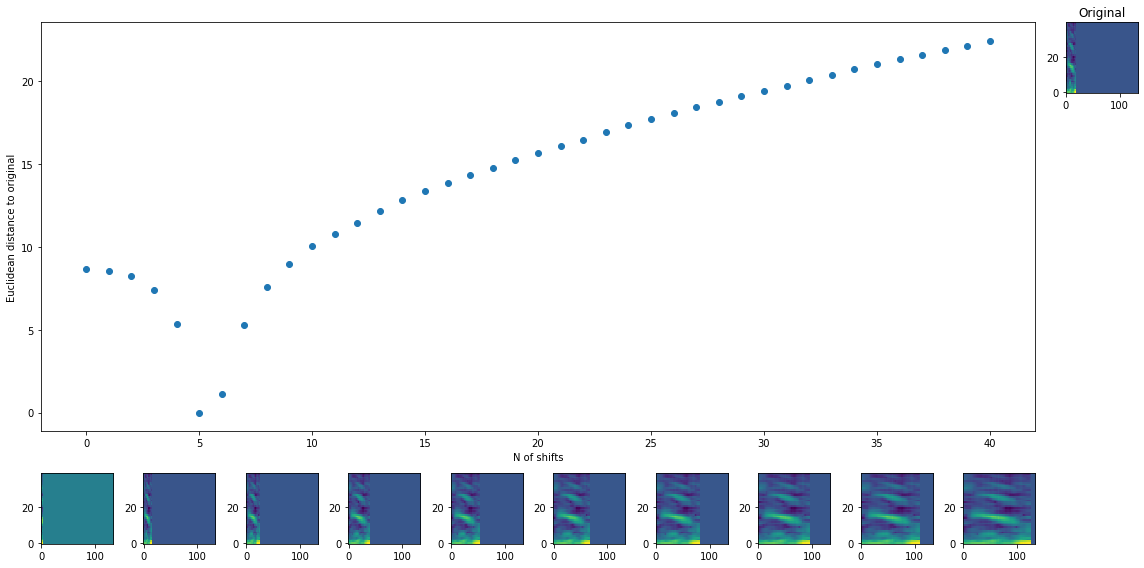

In [ ]:
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(5, 11, fig)
fig.add_subplot(gs[:4, :10])
plt.scatter(range(len(augmented_specs)), distances)
plt.ylabel('Euclidean distance to original')
plt.xlabel('N of shifts')

# original spec on the very left
fig.add_subplot(gs[0, 10])
plt.imshow(original_spec, interpolation='nearest', origin='lower', aspect='auto') 
plt.title('Original')

# the augmented specs to the right
interval_specs = np.linspace(0, len(augmented_specs)-1, num=10).astype(int)
for i in range(10):
  fig.add_subplot(gs[4, i])
  plt.imshow(augmented_specs[interval_specs[i]], interpolation='nearest', origin='lower', aspect='auto') 

plt.tight_layout()

### Embeddings

In [ ]:
import umap

In [ ]:
specs = list(df.denoised_spectrograms.values) # now array of 2D arrays n_mels+time_frames(varying)
MAXLEN = np.max([spec.shape[1] for spec in specs])

original_spec = call_dict[calltype].denoised_spectrograms

augmented_specs = generate_augmented(call_dict[calltype], augment_type)

# Add augmented to dataframe
specs = list(df.denoised_spectrograms.values) # now array of 2D arrays n_mels+time_frames(varying)
specs = specs+augmented_specs
len(specs)

flattened_specs = [pad_spectro(spec, MAXLEN).flatten() for spec in specs]
data = np.asarray(flattened_specs)
# Normalize
#data = StandardScaler().fit_transform(pd.DataFrame(data))
data.shape

(6728, 5360)

In [ ]:
# UMAP
reducer = umap.UMAP(low_memory=True, n_components = 10, min_dist=0)
embedding = reducer.fit_transform(data)
embedding.shape

(6728, 10)

In [ ]:
specs_embeddings = embedding[0:-(len(augmented_specs)),:]
original_embedding = embedding[df.loc[df['index_id'] == call_dict[calltype].index_id,:].index[0],:]
augmented_embeddings = embedding[-(len(augmented_specs)):,:]


if augment_type=='stretch':
  lens = [spec.shape[1] for spec in augmented_specs]
  zero_stretch_index = lens.index(original_spec.shape[1])
  original_embedding = augmented_embeddings[zero_stretch_index,:]
  original_spec = augmented_specs[zero_stretch_index]


if augment_type!='freqshift':
  original_spec = pad_spectro(original_spec, MAXLEN)
  augmented_specs = [pad_spectro(x, MAXLEN) for x in augmented_specs]

distances = [euclid(original_embedding, augmented_embeddings[i,:]) for i in range(0,len(augmented_specs))]

In [ ]:
#plt.scatter(range(len(augmented_specs)), distances)

#### Visualization

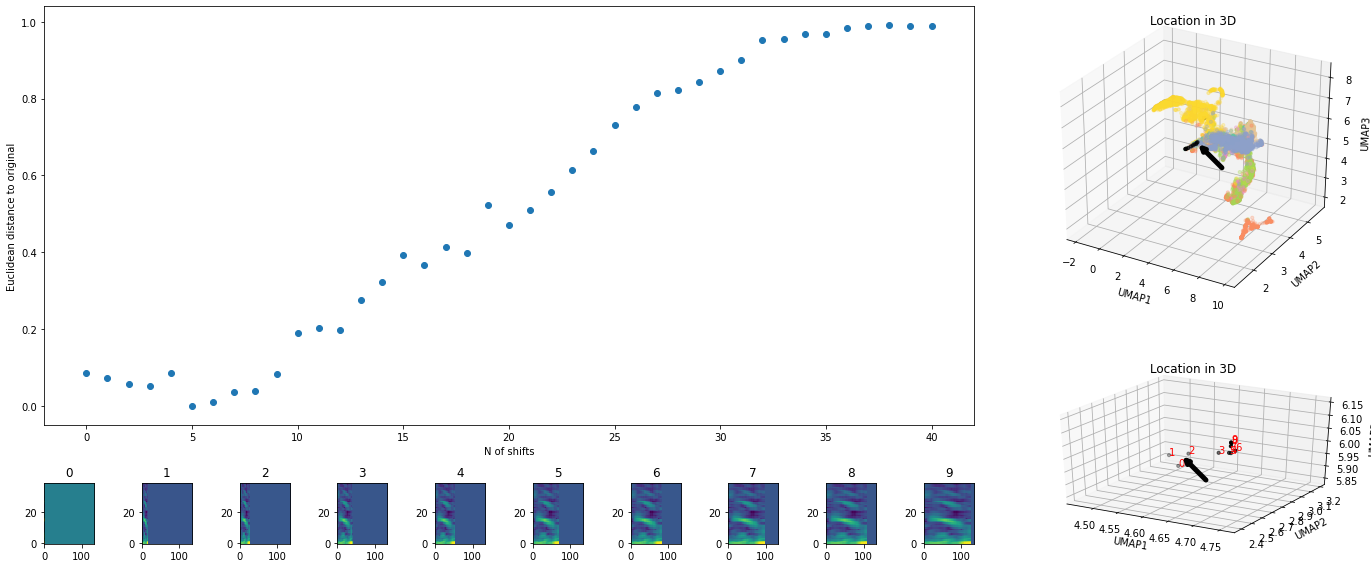

In [ ]:
interval_specs = np.linspace(0, len(augmented_specs)-1, num=10).astype(int)
augmented_10_embeddings = augmented_embeddings[interval_specs,:]
plot_embedding = np.concatenate((specs_embeddings, augmented_10_embeddings), axis=0)
original_row_num = df.loc[df['index_id'] == call_dict[calltype].index_id,:].index[0]

fig = plt.figure(figsize=(20,8))
gs = gridspec.GridSpec(5, 15, fig)
fig.add_subplot(gs[:4, 1:11])
plt.scatter(range(len(augmented_specs)), distances)
plt.ylabel('Euclidean distance to original')
plt.xlabel('N of shifts')


# the augmented specs to the right
for i in range(10):
  fig.add_subplot(gs[4, i+1])
  plt.imshow(augmented_specs[interval_specs[i]], interpolation='nearest', origin='lower', aspect='auto')
  plt.title(str(i))

ax = fig.add_subplot(gs[0:3, 11:], projection='3d')
#ax = fig.add_subplot(111, projection='3d')

scat_labels = df['call_lable'].copy()
labeltypes = sorted(list(set(scat_labels)))

# makes colors same as AVGN visualization
pal = sns.color_palette("Set2", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))

# change alpha param
for key in color_dict.keys():
  color_dict[key] = color_dict[key] +(0.5,)

# add special entry for augmented specs
color_dict[99] = (0,0,0,1) # black

scat_labels = np.asarray(scat_labels)
scat_labels[original_row_num] = 99
scat_labels = list(scat_labels)
scat_labels = scat_labels+[99]*10

# Adding color for representative datapoints
c = [color_dict[val] for val in scat_labels]

Axes3D.scatter(ax,
               #xs = embedding[:-len(augmented_specs),0],
               #ys = embedding[:-len(augmented_specs),1],
               #zs= embedding[:-len(augmented_specs),2],
               xs = plot_embedding[:,0],
               ys = plot_embedding[:,1],
               zs= plot_embedding[:,2],
               zdir='z',
               s=10,
               label = c,
               c=c,
               depthshade=True)

# put in arrow
if augment_type=='stretch':
  ax.annotate3D('',(augmented_embeddings[zero_stretch_index,0],augmented_embeddings[zero_stretch_index,1],augmented_embeddings[zero_stretch_index,2]),
                xytext=(30,-30),
                textcoords='offset points',
                bbox=dict(boxstyle="round", fc="lightyellow"),
                arrowprops = dict(arrowstyle="-|>",ec='black', fc='white', lw=5))
else:
  ax.annotate3D('',(embedding[original_row_num,0],embedding[original_row_num,1],embedding[original_row_num,2]),
                xytext=(30,-30),
                textcoords='offset points',
                bbox=dict(boxstyle="round", fc="lightyellow"),
                arrowprops = dict(arrowstyle="-|>",ec='black', fc='white', lw=5))


ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
ax.set_title('Location in 3D')


ax = fig.add_subplot(gs[3:, 11:], projection='3d')
scat_labels = np.arange(0,10,1)
c = [(0,0,0,1) for val in scat_labels]

Axes3D.scatter(ax,
               #xs = embedding[:-len(augmented_specs),0],
               #ys = embedding[:-len(augmented_specs),1],
               #zs= embedding[:-len(augmented_specs),2],
               xs = augmented_10_embeddings[:,0],
               ys = augmented_10_embeddings[:,1],
               zs= augmented_10_embeddings[:,2],
               zdir='z',
               s=10,
               label = c,
               c=c,
               depthshade=True)

# put in arrow
if augment_type=='stretch':
  ax.annotate3D('',(augmented_embeddings[zero_stretch_index,0],augmented_embeddings[zero_stretch_index,1],augmented_embeddings[zero_stretch_index,2]),
                xytext=(30,-30),
                textcoords='offset points',
                bbox=dict(boxstyle="round", fc="lightyellow"),
                arrowprops = dict(arrowstyle="-|>",ec='black', fc='white', lw=5))
else:
  ax.annotate3D('',(embedding[original_row_num,0],embedding[original_row_num,1],embedding[original_row_num,2]),
                xytext=(30,-30),
                textcoords='offset points',
                bbox=dict(boxstyle="round", fc="lightyellow"),
                arrowprops = dict(arrowstyle="-|>",ec='black', fc='white', lw=5))

# simple way, only text, no arrow:
for i in scat_labels:
  ax.text(augmented_10_embeddings[i,0],
          augmented_10_embeddings[i,1],
          augmented_10_embeddings[i,2],
          str(i), color='red')


ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
ax.set_title('Location in 3D')


plt.tight_layout() 

#plt.savefig(FIGURES+'augment_'+calltype+'.jpg')

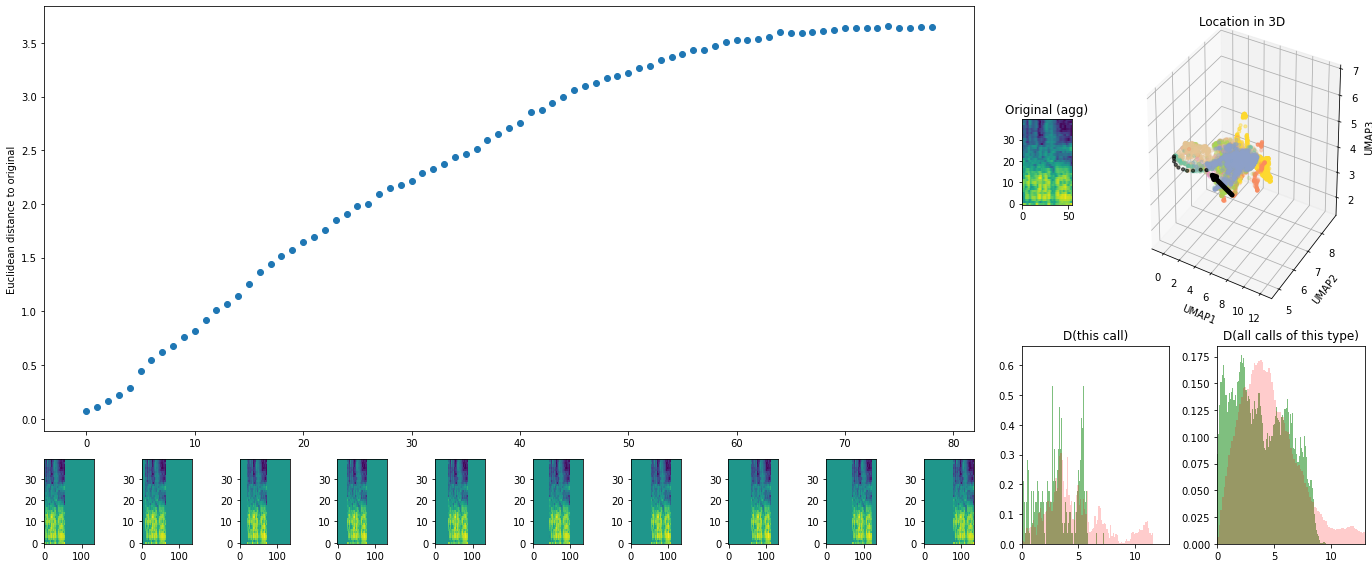

In [ ]:
ymax = int(np.max([np.max(distmat_call_vals), 
               np.max(distmat_not_call_vals),
               np.max(distmat_call_vals_1),
               np.max(distmat_not_call_vals_1),
               ]))

interval_specs = np.linspace(0, len(augmented_specs)-1, num=10).astype(int)
augmented_10_embeddings = augmented_embeddings[interval_specs,:]
plot_embedding = np.concatenate((specs_embeddings, augmented_10_embeddings), axis=0)
original_row_num = df.loc[df['index_id'] == call_dict[calltype].index_id,:].index[0]

fig = plt.figure(figsize=(20,8))
gs = gridspec.GridSpec(5, 15, fig)
fig.add_subplot(gs[:4, 1:11])
plt.scatter(range(len(augmented_specs)), distances)
plt.ylabel('Euclidean distance to original')

# the augmented specs to the right
for i in range(10):
  fig.add_subplot(gs[4, i+1])
  plt.imshow(augmented_specs[interval_specs[i]], interpolation='nearest', origin='lower', aspect='auto') 

fig.add_subplot(gs[1:2, 11:12])
plt.imshow(call_dict[calltype].denoised_spectrograms, interpolation='nearest', origin='lower', aspect='auto') 
plt.title("Original ("+call_dict[calltype].call_lable+")")

fig.add_subplot(gs[3:5, 11:13])
n, bins, patches = plt.hist(distmat_call_vals_1, bins=100, alpha=0.5, color='green', density=True)
n, bins, patches = plt.hist(distmat_not_call_vals_1, bins=100, alpha=0.2, color='red', density=True)
plt.xlim([0, ymax])
plt.title("D(this call)")

fig.add_subplot(gs[3:5, 13:])
n, bins, patches = plt.hist(distmat_call_vals, bins=100, alpha=0.5, color='green',density=True)
n, bins, patches = plt.hist(distmat_not_call_vals, bins=100, alpha=0.2, color='red',density=True)
plt.xlim([0, ymax])
plt.title("D(all calls of this type)")

ax = fig.add_subplot(gs[0:3, 12:], projection='3d')
#ax = fig.add_subplot(111, projection='3d')

scat_labels = df['call_lable'].copy()
labeltypes = sorted(list(set(scat_labels)))

# makes colors same as AVGN visualization
pal = sns.color_palette("Set2", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))

# change alpha param
for key in color_dict.keys():
  color_dict[key] = color_dict[key] +(0.5,)

# add special entry for augmented specs
color_dict[99] = (0,0,0,1) # black

scat_labels = np.asarray(scat_labels)
scat_labels[original_row_num] = 99
scat_labels = list(scat_labels)
scat_labels = scat_labels+[99]*10

# Adding color for representative datapoints
c = [color_dict[val] for val in scat_labels]

Axes3D.scatter(ax,
               #xs = embedding[:-len(augmented_specs),0],
               #ys = embedding[:-len(augmented_specs),1],
               #zs= embedding[:-len(augmented_specs),2],
               xs = plot_embedding[:,0],
               ys = plot_embedding[:,1],
               zs= plot_embedding[:,2],
               zdir='z',
               s=10,
               label = c,
               c=c,
               depthshade=True)

# put in arrow
ax.annotate3D('',(embedding[original_row_num,0],embedding[original_row_num,1],embedding[original_row_num,2]),
              xytext=(30,-30),
              textcoords='offset points',
              bbox=dict(boxstyle="round", fc="lightyellow"),
              arrowprops = dict(arrowstyle="-|>",ec='black', fc='white', lw=5))

ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
ax.set_title('Location in 3D')

plt.tight_layout() 

plt.savefig(FIGURES+'augment_'+calltype+'.jpg')

# Try with UMAP transform of augmented specs

Run UMAP once with the original dataset. Then create augmented specs, encode them as part of the full dataframe (because of z-transform), then project them into existing UMAP space.

In [ ]:
# Original embeddings (only once)

specs = list(df.denoised_spectrograms.values) # now array of 2D arrays n_mels+time_frames(varying)
MAXLEN = np.max([spec.shape[1] for spec in specs])
# Create data
flattened_specs = [pad_spectro(spec, MAXLEN).flatten() for spec in specs]
data = np.asarray(flattened_specs)
# Normalize
#data = StandardScaler().fit_transform(pd.DataFrame(data))


# UMAP
reducer = umap.UMAP(low_memory=True, n_components = 10, min_dist=0)
umap_res = reducer.fit(data)
specs_embeddings = umap_res.embedding_
specs_embeddings.shape


(6687, 10)

In [ ]:
# Create augmented specs

original_spec = call_dict[calltype].denoised_spectrograms

augmented_specs = []

for k in range(1,(MAXLEN-original_spec.shape[1])):
  addition = np.zeros((original_spec.shape[0], k))
  augmented = np.append(addition, original_spec, axis=1)
  augmented_specs.append(augmented)

all_specs = specs+augmented_specs

# Create data
all_flattened_specs = [pad_spectro(spec, MAXLEN).flatten() for spec in all_specs]
all_data = np.asarray(all_flattened_specs)
# Normalize
#all_data = StandardScaler().fit_transform(pd.DataFrame(all_data))

augmented_data = all_data[-len(augmented_specs):,:]
augmented_data.shape

(101, 5360)

In [ ]:
# Project these new datapoints into UMAP space:
augmented_embeddings = umap_res.transform(augmented_data)

In [ ]:
# Calculate distances

original_embedding = specs_embeddings[df.loc[df['index_id'] == call_dict[calltype].index_id,:].index[0],:]
distances = [euclid(original_embedding, augmented_embeddings[i,:]) for i in range(0,len(augmented_specs))]

# Pad for plot
original_spec = pad_spectro(original_spec, MAXLEN)
augmented_specs = [pad_spectro(x, MAXLEN) for x in augmented_specs]

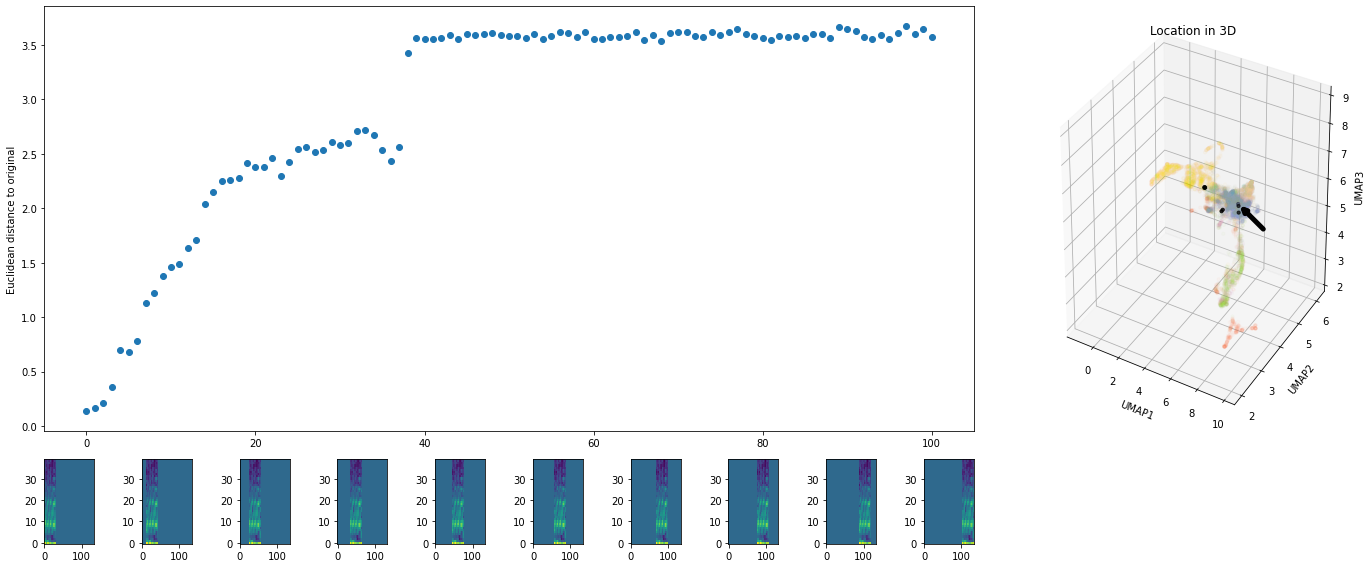

In [ ]:

interval_specs = np.linspace(0, len(augmented_specs)-1, num=10).astype(int)
augmented_10_embeddings = augmented_embeddings[interval_specs,:]
plot_embedding = np.concatenate((specs_embeddings, augmented_10_embeddings), axis=0)
original_row_num = df.loc[df['index_id'] == call_dict[calltype].index_id,:].index[0]

fig = plt.figure(figsize=(20,8))
gs = gridspec.GridSpec(5, 15, fig)
fig.add_subplot(gs[:4, 1:11])
plt.scatter(range(len(augmented_specs)), distances)
plt.ylabel('Euclidean distance to original')

# the augmented specs to the right
for i in range(10):
  fig.add_subplot(gs[4, i+1])
  plt.imshow(augmented_specs[interval_specs[i]], interpolation='nearest', origin='lower', aspect='auto') 

ax = fig.add_subplot(gs[0:4, 11:], projection='3d')
#ax = fig.add_subplot(111, projection='3d')

scat_labels = df['call_lable'].copy()
labeltypes = sorted(list(set(scat_labels)))

# makes colors same as AVGN visualization
pal = sns.color_palette("Set2", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))

# change alpha param
for key in color_dict.keys():
  color_dict[key] = color_dict[key] +(0.05,)

# add special entry for augmented specs
color_dict[99] = (0,0,0,1) # black

scat_labels = np.asarray(scat_labels)
scat_labels[original_row_num] = 99
scat_labels = list(scat_labels)
scat_labels = scat_labels+[99]*10

# Adding color for representative datapoints
c = [color_dict[val] for val in scat_labels]

Axes3D.scatter(ax,
               #xs = embedding[:-len(augmented_specs),0],
               #ys = embedding[:-len(augmented_specs),1],
               #zs= embedding[:-len(augmented_specs),2],
               xs = plot_embedding[:,0],
               ys = plot_embedding[:,1],
               zs= plot_embedding[:,2],
               zdir='z',
               s=10,
               label = c,
               c=c,
               depthshade=True)

# put in arrow
ax.annotate3D('',(plot_embedding[original_row_num,0],plot_embedding[original_row_num,1],plot_embedding[original_row_num,2]),
              xytext=(30,-30),
              textcoords='offset points',
              bbox=dict(boxstyle="round", fc="lightyellow"),
              arrowprops = dict(arrowstyle="-|>",ec='black', fc='white', lw=5))

ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
ax.set_title('Location in 3D')

plt.tight_layout() 

#plt.savefig(FIGURES+'augment_'+calltype+'.jpg')

In [ ]:
import math
10*math.log(0.5,10)

-3.0102999566398116

In [ ]:
print(math.log(0.5,10))
print(10**0.3)

-0.30102999566398114
1.9952623149688795


# Test spectrogram generation

There's a difference between spectrograms generated with phase vocoder and stretch parameter 1 (no stretch) and the original. Find out why.


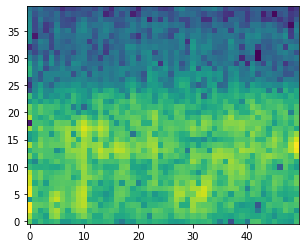

In [ ]:
plt.imshow(augmented_specs[16], interpolation='nearest', origin='lower', aspect='equal') 

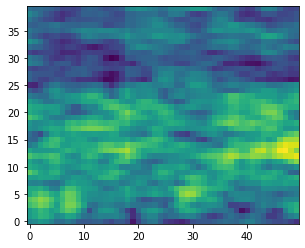

In [ ]:
plt.imshow(original_spec, interpolation='nearest', origin='lower', aspect='equal') 

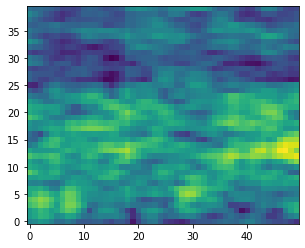

In [ ]:
example = call_dict['agg']
plt.imshow(example.denoised_spectrograms, interpolation='nearest', origin='lower', aspect='equal') 

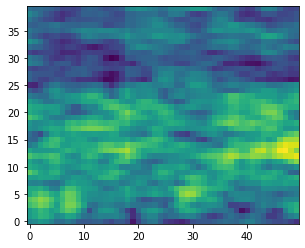

In [ ]:
# Reproduce with old pipeline

def generate_mel_spectrogram(data, rate, n_mels, window, fft_win , fft_hop):
    n_fft  = int(fft_win * rate) 
    hop_length = int(fft_hop * rate) 
        
    s = librosa.feature.melspectrogram(y = data ,
                                       sr = rate, 
                                       n_mels = n_mels , 
                                       fmax = 4000, 
                                       n_fft = n_fft,
                                       hop_length = hop_length, 
                                       window = window, 
                                       win_length = n_fft)

    spectro = librosa.power_to_db(s, ref=np.max)

    return spectro


spectrogram = generate_mel_spectrogram(example.raw_audio, example.samplerate_hz,
                                       N_MELS,WINDOW,FFT_WIN,FFT_HOP)
spectrogram = spectrogram - np.median(spectrogram, axis=0)
plt.imshow(spectrogram, interpolation='nearest', origin='lower', aspect='equal') 

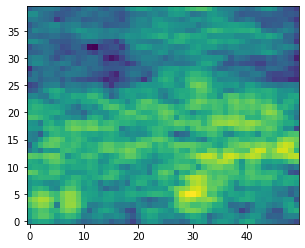

In [ ]:
# Produce with vocoder stretch. First without stretch. Just to compare.
def generate_stretched_mel_spectrogram(data, sr, duration, n_mels, window, fft_win , fft_hop):
    n_fft  = int(fft_win * sr) 
    hop_length = int(fft_hop * sr) 
    
    stretch_rate = 1

    D = librosa.stft(y=data, # spectrogramming
                     n_fft = n_fft,
                     hop_length = hop_length,
                     window=window,
                     win_length = n_fft
                     )
    
    D_stretched = librosa.core.phase_vocoder(D, stretch_rate, hop_length=hop_length) # stretch spectrogram
    
    D_stretched = librosa.power_to_db(np.abs(D_stretched)**2, ref=np.max) # power to db transform

    s = librosa.feature.melspectrogram(S=D_stretched,  # mel transform
                                       sr=sr,
                                       n_mels=n_mels,
                                       fmax=4000)
    
    #s = librosa.power_to_db(np.abs(s)**2, ref=np.max) # power to db transform
    
    return s

stretched_spec = generate_stretched_mel_spectrogram(example.raw_audio, example.samplerate_hz, example.duration_s, N_MELS, WINDOW, FFT_WIN, FFT_HOP)
plt.imshow(stretched_spec, interpolation='nearest', origin='lower', aspect='equal') 

# Reste

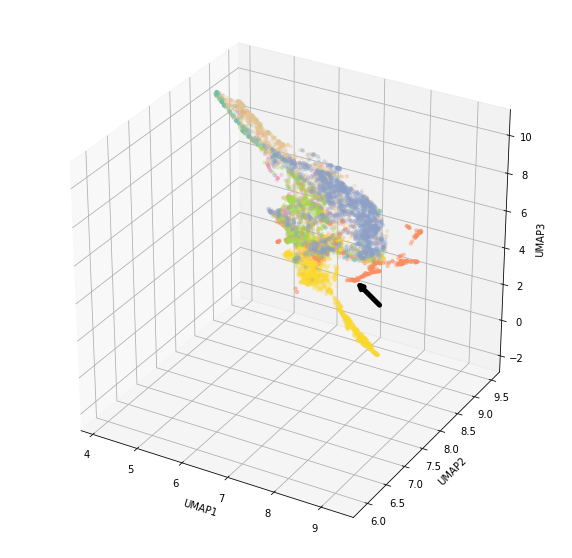

In [ ]:
original_row_num = df.loc[df['index_id'] == call_dict[calltype].index_id,:].index[0]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

scat_labels = df['call_lable'].copy()
labeltypes = sorted(list(set(scat_labels)))

# makes colors same as AVGN visualization
pal = sns.color_palette("Set2", n_colors=len(labeltypes))

color_dict = dict(zip(labeltypes, pal))

for key in color_dict.keys():
  color_dict[key] = color_dict[key] +(0.5,)
color_dict[99] = (0,0,0,1) # black

scat_labels = np.asarray(scat_labels)
scat_labels[original_row_num] = 99
scat_labels = list(scat_labels)

# Adding color for representative datapoints
c = [color_dict[val] for val in scat_labels]

Axes3D.scatter(ax,
               xs = embedding[:-len(augmented_specs),0],
               ys = embedding[:-len(augmented_specs),1],
               zs= embedding[:-len(augmented_specs),2],
               zdir='z',
               s=10,
               label = c,
               c=c,
               depthshade=True)

# simple way, only text, no arrow:
#ax.text(embedding[original_row_num,0],
#        embedding[original_row_num,1],
#        embedding[original_row_num,2],
#        "example", color='red')

# put in arrow
ax.annotate3D('',(embedding[original_row_num,0],embedding[original_row_num,1],embedding[original_row_num,2]),
              xytext=(30,-30),
              textcoords='offset points',
              bbox=dict(boxstyle="round", fc="lightyellow"),
              arrowprops = dict(arrowstyle="-|>",ec='black', fc='white', lw=5))

ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')

plt.show()

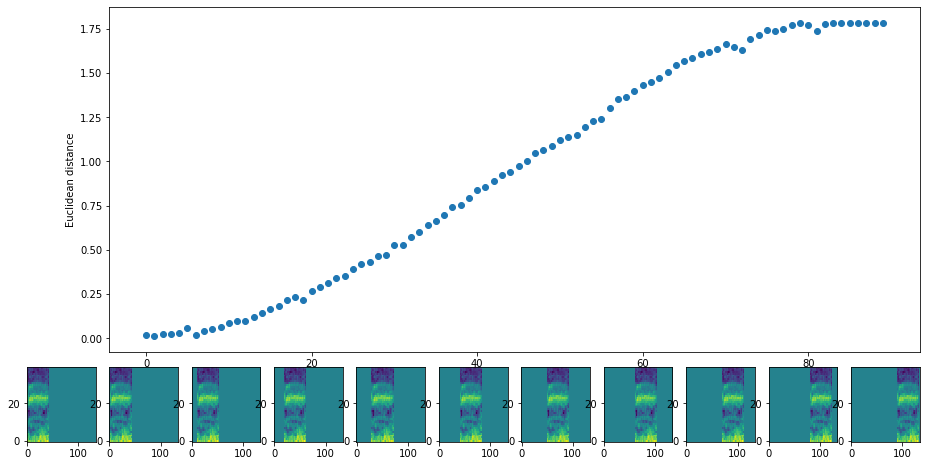

In [ ]:
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(5, 11, fig)
fig.add_subplot(gs[:4, 1:])
plt.scatter(range(len(augmented_specs)), distances)
plt.ylabel('Euclidean distance')

# original spec on the very left
fig.add_subplot(gs[4, 0])
plt.imshow(original_spec, interpolation='nearest', origin='lower', aspect='auto') 

# the augmented specs to the right
interval_specs = np.linspace(0, len(augmented_specs)-1, num=10).astype(int)
for i in range(10):
  fig.add_subplot(gs[4, i+1])
  plt.imshow(augmented_specs[interval_specs[i]], interpolation='nearest', origin='lower', aspect='auto') 

In [ ]:
# distances within the same calltype
data_call = specs_embeddings[df.loc[df['call_lable'] == calltype,:].index,:]
distmat_call = distance_matrix(data_call, data_call, p=2)
distmat_call_vals = distmat_call.flatten()
distmat_call_vals = np.delete(distmat_call_vals, np.argwhere(distmat_call_vals == 0))


# distances to other calltypes
data_not_call = specs_embeddings[df.loc[df['call_lable'] != calltype,:].index,:]
distmat_call = distance_matrix(data_call, data_not_call, p=2)
distmat_not_call_vals = distmat_call.flatten()
distmat_not_call_vals = np.delete(distmat_not_call_vals, np.argwhere(distmat_not_call_vals == 0))

# the specific call

# to all other calltypes of that type
distmat_call = distance_matrix(data_call, np.reshape(original_embedding, (1, original_embedding.shape[0])), p=2)
distmat_call_vals_1 = distmat_call.flatten()
distmat_call_vals_1 = np.delete(distmat_call_vals_1, np.argwhere(distmat_call_vals_1 == 0))

# to all other calltypes NOT of that type
distmat_call = distance_matrix(np.reshape(original_embedding, (1, original_embedding.shape[0])), data_not_call, p=2)
distmat_not_call_vals_1 = distmat_call.flatten()
#distmat_not_call_vals_1 = np.delete(distmat_not_call_vals_1, np.argwhere(distmat_not_call_vals_1 == 0))

n, bins, patches = plt.hist(distmat_call_vals, bins=100, alpha=0.5, color='green')
n, bins, patches = plt.hist(distmat_not_call_vals, bins=100, alpha=0.2, color='red')
#plt.xlim([0, 14])
plt.title("All calls")
plt.show()

n, bins, patches = plt.hist(distmat_call_vals_1, bins=100, alpha=0.5, color='green')
n, bins, patches = plt.hist(distmat_not_call_vals_1, bins=100, alpha=0.2, color='red')
#plt.xlim([0, 14])
plt.title("Specific call")
plt.show()

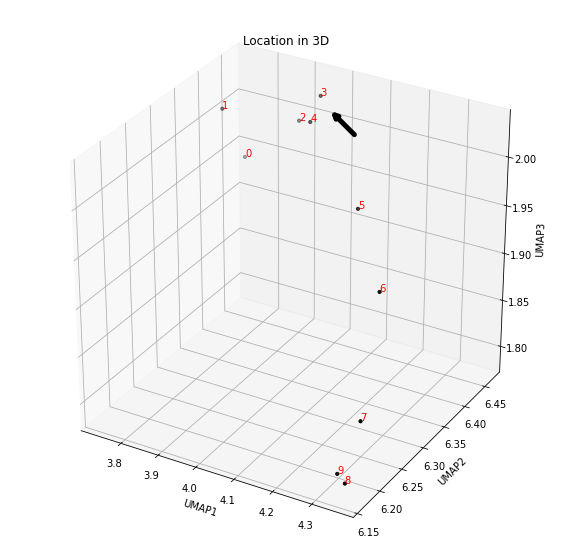

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

scat_labels = np.arange(0,10,1)
c = [(0,0,0,1) for val in scat_labels]

Axes3D.scatter(ax,
               #xs = embedding[:-len(augmented_specs),0],
               #ys = embedding[:-len(augmented_specs),1],
               #zs= embedding[:-len(augmented_specs),2],
               xs = augmented_10_embeddings[:,0],
               ys = augmented_10_embeddings[:,1],
               zs= augmented_10_embeddings[:,2],
               zdir='z',
               s=10,
               label = c,
               c=c,
               depthshade=True)

# put in arrow
if augment_type=='stretch':
  ax.annotate3D('',(augmented_embeddings[zero_stretch_index,0],augmented_embeddings[zero_stretch_index,1],augmented_embeddings[zero_stretch_index,2]),
                xytext=(30,-30),
                textcoords='offset points',
                bbox=dict(boxstyle="round", fc="lightyellow"),
                arrowprops = dict(arrowstyle="-|>",ec='black', fc='white', lw=5))
else:
  ax.annotate3D('',(embedding[original_row_num,0],embedding[original_row_num,1],embedding[original_row_num,2]),
                xytext=(30,-30),
                textcoords='offset points',
                bbox=dict(boxstyle="round", fc="lightyellow"),
                arrowprops = dict(arrowstyle="-|>",ec='black', fc='white', lw=5))

# simple way, only text, no arrow:
for i in scat_labels:
  ax.text(augmented_10_embeddings[i,0],
          augmented_10_embeddings[i,1],
          augmented_10_embeddings[i,2],
          str(i), color='red')


ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
ax.set_title('Location in 3D')
plt.show()

# Files for Frants

In [ ]:
df.shape

(6687, 36)

In [ ]:
def extract_padded(id, label, wav_loc, start_s, duration_s):
 
  duration_s = duration_s+0.2
  start_s = start_s-0.1

  filename = str(id)+'_'+label+'.wav'

  if start_s>0:
    data, rate = librosa.load(wav_loc, offset=start_s, duration=duration_s, sr=None, mono=False)
    librosa.output.write_wav(DATA+'frants_padded/padded_'+filename, data, rate, norm=False)

In [ ]:
x=df.apply(lambda row: extract_padded(row['index_id'],
                                    row['call_lable'],
                                    row['original_wav'],
                                    row['start_s'],
                                    row['duration_s']),
         axis=1)
